In [448]:
from collections.abc import Iterator
from functools import partial
from typing import Any
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps, ImageStat, ImageCms
from io import BytesIO
import h5py as h5

In [449]:
def list_images(path: Path) -> Iterator[Path]:
    return path.glob("**/*.jpg")

In [488]:
data_path = Path("./data")
img_paths = list(list_images(data_path))
target_id = 5019
target_res = (100, 100)
thumb_res = (50, 50)

In [489]:
def get_image(path: Path) -> Image:
    return Image.open(path)

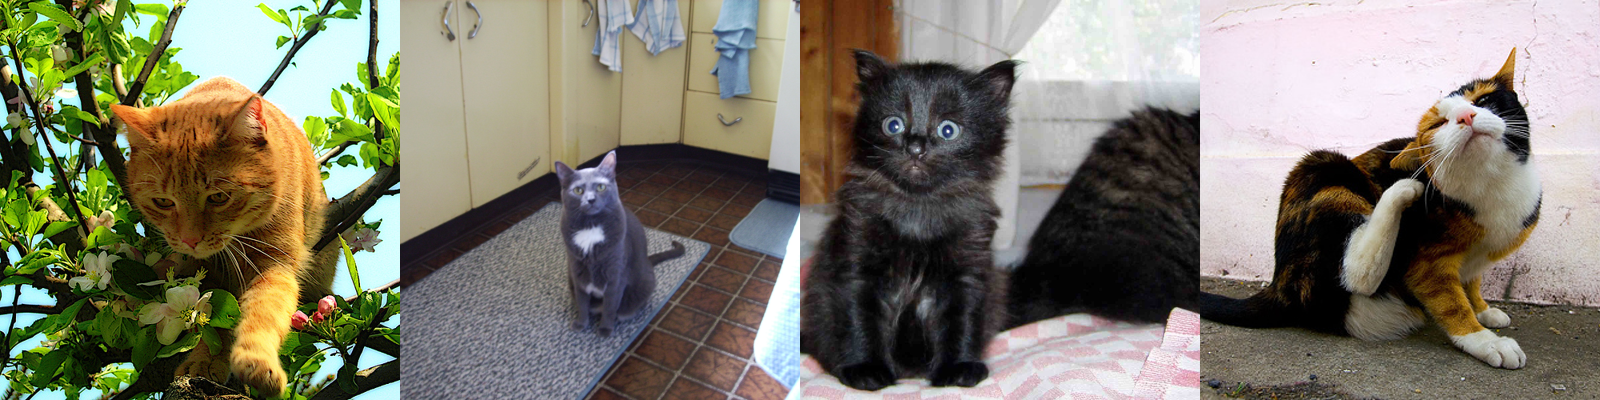

In [527]:
collage = Image.new("RGB", (1600, 400))
for i in range(4):
    collage.paste(ImageOps.fit(get_image(img_paths[target_id + i]), (400,400)), (i*400, 0))
collage.save("fig/collage.jpg")
collage

In [492]:
def process(img: Image) -> Image:
    return ImageOps.fit(img, thumb_res)

def encode_to_jpg(img: Image) -> bytes:
    f = BytesIO()
    img.save(f, "jpeg")
    return f.getbuffer()

def save_all(path: Path, jpgs: list[bytes]) -> None:
    with h5.File(path, "w") as out:
        for n, jpg in enumerate(jpgs):
            dataset = out.create_dataset(f"{n:06}", data=np.frombuffer(jpg, dtype='B'))

In [446]:
%%time
imgs = list(map(lambda x: process(get_image(x)), img_paths))

CPU times: user 1min 30s, sys: 1.34 s, total: 1min 31s
Wall time: 1min 38s


In [493]:
from dask.diagnostics import ProgressBar
from dask import bag as db
from dask import delayed

wf = db.from_sequence(img_paths, npartitions=1000).map(get_image).map(process).map(encode_to_jpg)

with ProgressBar():
    jpgs = wf.compute()

[########################################] | 100% Completed | 23.8s


In [494]:
save_all(data_path / "tiny_imgs.h5", jpgs)

In [455]:
%%time
save_all(data_path / "tiny_imgs.h5", map(encode_to_jpg, imgs))

CPU times: user 5.19 s, sys: 206 ms, total: 5.4 s
Wall time: 5.37 s


---
## Compute colors

In [456]:
import pandas as pd

In [457]:
from plotnine import ggplot, geom_point, aes
from matplotlib import pyplot as plt

In [495]:
with h5.File(data_path / "tiny_imgs.h5", "r") as f:
    imgs = [Image.open(BytesIO(f[n][:]), formats=["jpeg"]) for n in f]

In [496]:
rgb_stats = pd.DataFrame([ImageStat.Stat(img).mean for img in imgs], columns=["r", "g", "b"])

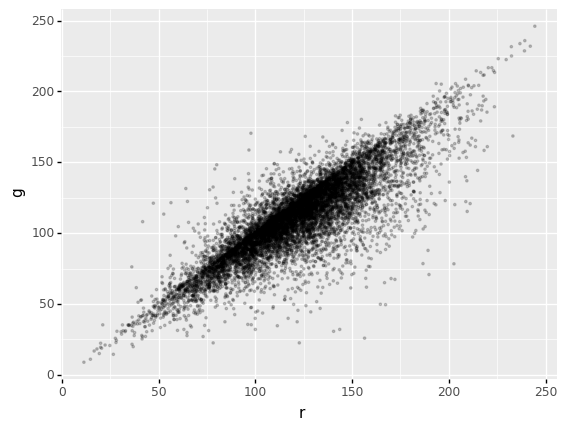

<ggplot: (8793518739173)>

In [501]:
ggplot(rgb_stats, aes(x="r", y="g")) + geom_point(alpha=0.2, shape='.')

In [497]:
srgb_p = ImageCms.createProfile("sRGB")
lab_p = ImageCms.createProfile("LAB")
rgb2lab = ImageCms.buildTransformFromOpenProfiles(srgb_p, lab_p, "RGB", "LAB")
lab2rgb = ImageCms.buildTransformFromOpenProfiles(lab_p, srgb_p, "LAB", "RGB")
lab_imgs = [ImageCms.applyTransform(im, rgb2lab) for im in imgs]

In [498]:
lab_stats = pd.DataFrame([ImageStat.Stat(im).mean for im in lab_imgs], columns=["L", "a", "b"])

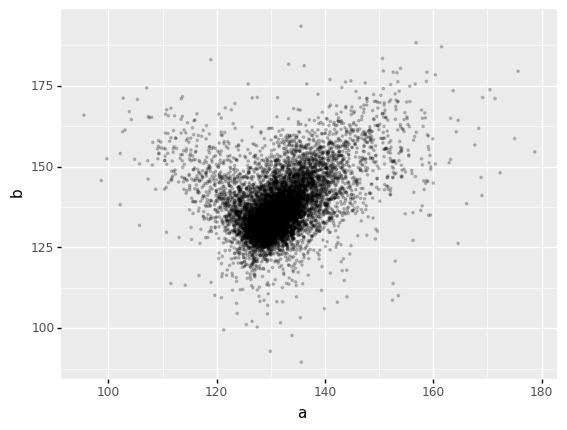

<ggplot: (8793518485426)>

In [499]:
ggplot(lab_stats, aes(x="a", y="b")) + geom_point(alpha=0.2, shape='.')

In [507]:
target_rgb = get_image(img_paths[target_id])

In [508]:
target_lab = ImageCms.applyTransform(target_rgb, rgb2lab)

In [509]:
l, a, b = (np.array(ImageOps.fit(target_lab, target_res).getdata(band)).reshape(target_res)
           for band in range(3))
lab_pixels = pd.DataFrame(np.c_[l.flat, a.flat, b.flat], columns=["L", "a", "b"])

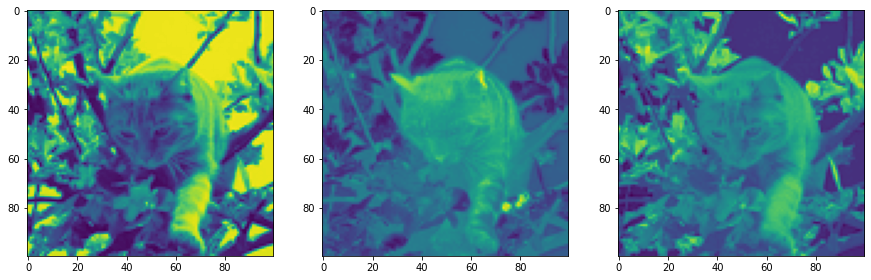

In [510]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(l)
ax[1].imshow(a)
ax[2].imshow(b)

In [511]:
r, g, b = (np.array(ImageOps.fit(target_rgb, target_res).getdata(band)).reshape(target_res)
           for band in range(3))
rgb_pixels = pd.DataFrame(np.c_[r.flat, g.flat, b.flat], columns=["r", "g", "b"])

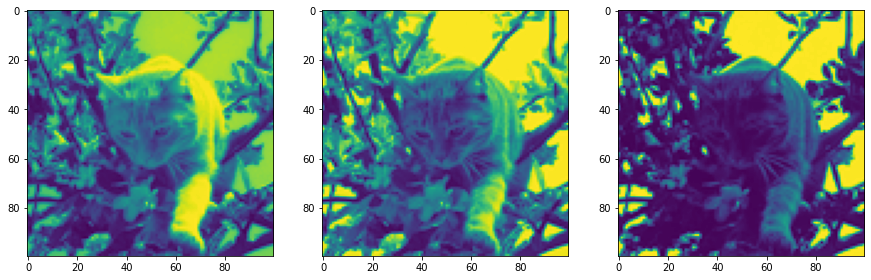

In [512]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(r)
ax[1].imshow(g)
ax[2].imshow(b)

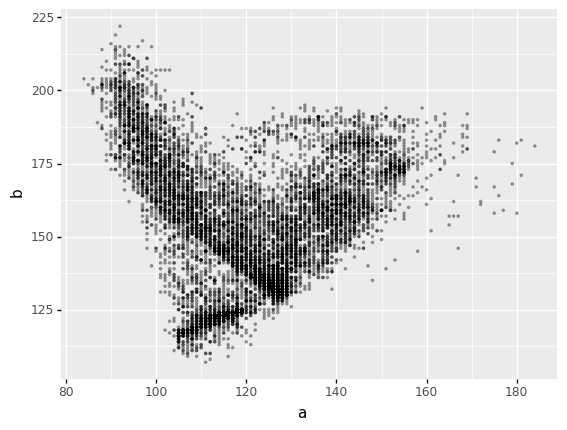

<ggplot: (8793516100874)>

In [513]:
ggplot(lab_pixels, aes(x="a", y="b")) + geom_point(alpha=0.3, shape='.')

## Optimal transport

In [514]:
import ot

In [515]:
n = len(lab_stats)
m = len(lab_pixels)
M = ot.dist(lab_stats.astype(float), lab_pixels.astype(float))
# M = ot.dist(rgb_stats.astype(float), rgb_pixels.astype(float))
M /= M.max()

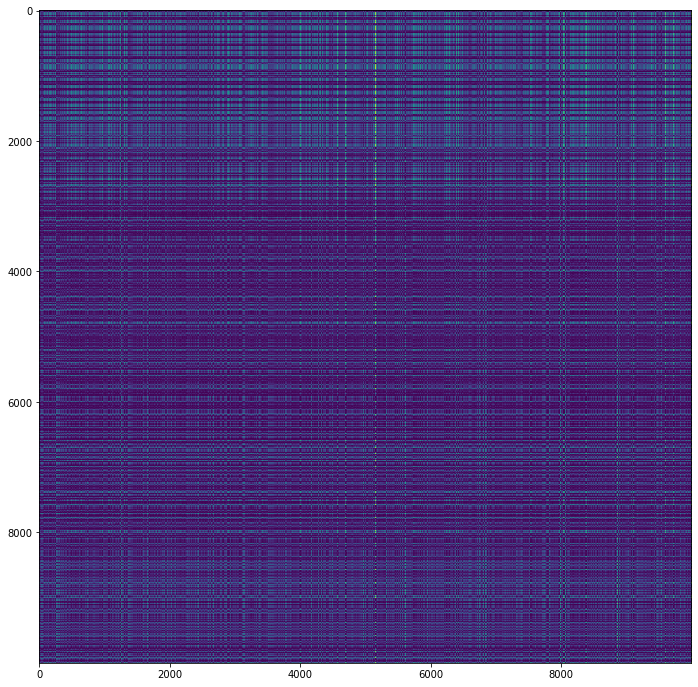

In [516]:
fig, ax = plt.subplots(1, 1, figsize=(24, 12))
ax.imshow(M.T, interpolation='nearest')

In [517]:
a = np.ones((n,)) / n
b = np.ones((m,)) / m
G0 = ot.emd(a, b, M, numItermax=10**6)

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 1000000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/johannes/.cache/pypoetry/virtualenvs/photo-mosaic-UPdgoPWi-py3.9/lib64/python3.9/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.


In [519]:
matches = np.argmin(M, axis=0)
print("Unique images used in nearest neighbour approach: {}".format(np.unique(matches).shape[0]))
np.savetxt(data_path / "matches_nearest.tab", matches.reshape(target_res), fmt="%d")

Unique images used in nearest neighbour approach: 861


In [520]:
matches = np.argmax(G0, axis=0)
print("Unique images used in optimal transport approach: {}".format(np.unique(matches).shape[0]))
np.savetxt(data_path / "matches_unique.tab", matches.reshape(target_res), fmt="%d")

Unique images used in optimal transport approach: 9997


## Construct mosaic

In [521]:
with h5.File(data_path / "tiny_imgs.h5", "r") as f:
    imgs = [Image.open(BytesIO(f[n][:]), formats=["jpeg"]) for n in f]
    
matches_nearest = np.loadtxt(data_path / "matches_nearest.tab", dtype=int)
matches_unique = np.loadtxt(data_path / "matches_unique.tab", dtype=int)

ys, xs = np.indices(target_res)

In [522]:
mosaic = Image.new("RGB", (target_res[0]*thumb_res[0], target_res[1]*thumb_res[1]))

In [523]:
for (x, y, m) in zip(xs.flat, ys.flat, matches_unique.flat):
    mosaic.paste(imgs[m], (x*thumb_res[0], y*thumb_res[1]))

mosaic.save("mosaic_unique.jpg")

In [524]:
for (x, y, m) in zip(xs.flat, ys.flat, matches_nearest.flat):
    mosaic.paste(imgs[m], (x*thumb_res[0], y*thumb_res[1]))

mosaic.save("mosaic_nearest.jpg")